# NICS Background Checks

<img src="https://www.fbi.gov/image-repository/firearm-sale.jpg/@@images/image/high" alt="drawing" width="300" height="200" align="left">




## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this data science project I chose to investigate the [**National Instant Criminal Background Check System (NICS)**](https://www.fbi.gov/services/cjis/nics/). 

The NICS conducts background checks on people who want to own a firearm or explosive, as required by law.

According to FBI's website:

> The National Instant Criminal Background Check System (NICS) was established as a result of the Brady Handgun Violence Prevention Act of 1993 (Brady Act) requirements. The Brady Act required a national namecheck system for federal firearms licensees (FFL).  FFLs, such as gun shop owners, pawn shop dealers, and retailers use NICS to determine whether a person can legally buy or own a firearm. Operated by the FBI, NICS was developed with the Bureau of Alcohol, Tobacco, Firearms and Explosives (ATF) and state and local law enforcement agencies.

>Note that **each check does not necessarily represent a firearm purchase**; however, background checks are commonly used as a measure of gun sales nationwide.

This dataset will be supplemented with the state level data from [census.gov](https://census.gov).

The questions that I will be exploring are:

* What days and months have the most background checks?
* What are the trends of background checks?
* What states have the most background checks per capita in 2016?
* Which states have had the highest growth in background checks between 2000 and 2020?

In [2]:
# import and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.style.use('seaborn')
% matplotlib inline

nics = pd.read_csv('nics-firearm-background-checks.csv',parse_dates=['month'])
census = pd.read_csv('us_census_data.csv')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Here I'll familiarize myself with the data. I'll view a few rows, check for duplicates and view the data types.

In [ ]:
nics.head() # view a few lines

month       state  ...  return_to_seller_other  totals
0 2021-04-01     Alabama  ...                     1.0   88232
1 2021-04-01      Alaska  ...                     0.0    9078
2 2021-04-01     Arizona  ...                     0.0   55830
3 2021-04-01    Arkansas  ...                     0.0   26952
4 2021-04-01  California  ...                     0.0  126285

[5 rows x 27 columns]

In [ ]:
nics.dtypes # check data types

month                        datetime64[ns]
state                                object
permit                              float64
permit_recheck                      float64
handgun                             float64
long_gun                            float64
other                               float64
multiple                              int64
admin                               float64
prepawn_handgun                     float64
prepawn_long_gun                    float64
prepawn_other                       float64
redemption_handgun                  float64
redemption_long_gun                 float64
redemption_other                    float64
returned_handgun                    float64
returned_long_gun                   float64
returned_other                      float64
rentals_handgun                     float64
rentals_long_gun                    float64
private_sale_handgun                float64
private_sale_long_gun               float64
private_sale_other              

In [ ]:
nics.duplicated().sum() # check for duplicates

0

The **NICS** Dataset looks pretty **clean**. The `month`, `state`, and `totals` are my **main columns** for analysis and they **are all in correct datatypes**. I don't expect much cleaning to do here. Except, dropping some irrelevant columns.

In [ ]:
census.head() # view a few lines

Fact  ...  Wyoming
0       Population estimates, July 1, 2016,  (V2016)  ...  585,501
1  Population estimates base, April 1, 2010,  (V2...  ...  563,767
2  Population, percent change - April 1, 2010 (es...  ...    3.90%
3                  Population, Census, April 1, 2010  ...  563,626
4  Persons under 5 years, percent, July 1, 2016, ...  ...    6.50%

[5 rows x 52 columns]

In [ ]:
census # viewing the head and tail

Fact  ...  Wyoming
0        Population estimates, July 1, 2016,  (V2016)  ...  585,501
1   Population estimates base, April 1, 2010,  (V2...  ...  563,767
2   Population, percent change - April 1, 2010 (es...  ...    3.90%
3                   Population, Census, April 1, 2010  ...  563,626
4   Persons under 5 years, percent, July 1, 2016, ...  ...    6.50%
..                                                ...  ...      ...
80                                                 FN  ...      NaN
81                                                NaN  ...      NaN
82                                                  S  ...      NaN
83                                                  X  ...      NaN
84                                                  Z  ...      NaN

[85 rows x 52 columns]

In [ ]:
census.dtypes # check data types

Fact              object
Fact Note         object
Alabama           object
Alaska            object
Arizona           object
Arkansas          object
California        object
Colorado          object
Connecticut       object
Delaware          object
Florida           object
Georgia           object
Hawaii            object
Idaho             object
Illinois          object
Indiana           object
Iowa              object
Kansas            object
Kentucky          object
Louisiana         object
Maine             object
Maryland          object
Massachusetts     object
Michigan          object
Minnesota         object
Mississippi       object
Missouri          object
Montana           object
Nebraska          object
Nevada            object
New Hampshire     object
New Jersey        object
New Mexico        object
New York          object
North Carolina    object
North Dakota      object
Ohio              object
Oklahoma          object
Oregon            object
Pennsylvania      object


In [ ]:
census.duplicated().sum() # check for duplicates

3

In [ ]:
census[census.duplicated()] # what rows have duplicates

Fact Fact Note Alabama Alaska  ... Washington West Virginia Wisconsin Wyoming
67  NaN       NaN     NaN    NaN  ...        NaN           NaN       NaN     NaN
70  NaN       NaN     NaN    NaN  ...        NaN           NaN       NaN     NaN
75  NaN       NaN     NaN    NaN  ...        NaN           NaN       NaN     NaN

[3 rows x 52 columns]

The **census** data will **need some cleaning**. Aside from removing unneccessary rows. I may have to transpose the dataframe to be able to join the **NICS** and **census** datasets. With shared index as the `state` columns.

My objectives for this dataset is to remove duplicates, drop unceccesary rows, transpose the dataframe, rename the columns as the names are too long and contains spaces. 

I am going to first remove the unncessary columns in census dataset, then make the states as the columns then I will transpose the resulting dataset, so that the census features are the columns then drop irrelevant columns for analysis. 

### Data Cleaning

Tasks:
* remove duplicates in census columns
* rename the index and columns
* transpose the dataframe so that the census features are the columns

In [ ]:
census.drop_duplicates(inplace=True) # drop duplicates

In [ ]:
census.duplicated().sum() # check if any more duplicates

0

In [ ]:
# create a function since I may have to repeat this step 
def col_rename(df):
    col_name = census.iloc[:,:1].values # get all the census features (all row but, only the first column)    
    col_name.tolist() # convert it to a list

    ind_label = {}
    for i,cv in enumerate(col_name): # create a dictionary of list of column names
        ind_label[i] = cv.tolist()[0] # keys are integers, values are column names
    return ind_label  

In [ ]:
census.rename(index=col_rename(census), inplace=True) # set index with the created dictionary of column names  
census.drop(columns=['Fact','Fact Note'], inplace=True) # remove unneccessary columns

In [ ]:
census.head() # view a few rows 

Alabama  ...  Wyoming
Population estimates, July 1, 2016,  (V2016)        4,863,300  ...  585,501
Population estimates base, April 1, 2010,  (V2016)  4,780,131  ...  563,767
Population, percent change - April 1, 2010 (est...      1.70%  ...    3.90%
Population, Census, April 1, 2010                   4,779,736  ...  563,626
Persons under 5 years, percent, July 1, 2016,  ...      6.00%  ...    6.50%

[5 rows x 50 columns]

Now that I have a work-able dataframe, I will transpose this so that the states are in index

In [ ]:
census = census.T # transpose the dataframe so the states are index and census features are the columns 

In [ ]:
census.head() # view the transposed dataframe

Population estimates, July 1, 2016,  (V2016)  ...   84
Alabama                                       4,863,300  ...  NaN
Alaska                                          741,894  ...  NaN
Arizona                                       6,931,071  ...  NaN
Arkansas                                      2,988,248  ...  NaN
California                                   39,250,017  ...  NaN

[5 rows x 82 columns]

In [ ]:
# view the columns of the census dataframe,
# to easily sift thru the columns, use enumerate to attach an index

for i,v in enumerate(census.columns):
  print(i,v) 

0 Population estimates, July 1, 2016,  (V2016)
1 Population estimates base, April 1, 2010,  (V2016)
2 Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)
3 Population, Census, April 1, 2010
4 Persons under 5 years, percent, July 1, 2016,  (V2016)
5 Persons under 5 years, percent, April 1, 2010
6 Persons under 18 years, percent, July 1, 2016,  (V2016)
7 Persons under 18 years, percent, April 1, 2010
8 Persons 65 years and over, percent,  July 1, 2016,  (V2016)
9 Persons 65 years and over, percent, April 1, 2010
10 Female persons, percent,  July 1, 2016,  (V2016)
11 Female persons, percent, April 1, 2010
12 White alone, percent, July 1, 2016,  (V2016)
13 Black or African American alone, percent, July 1, 2016,  (V2016)
14 American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)
15 Asian alone, percent, July 1, 2016,  (V2016)
16 Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)
17 Two or More Races, percent, 

In [ ]:
# drop the columns that are irrelevant to the analysis 
census = census.drop(census.columns[np.r_[ 1, 3:10, 11, 21:34, 36:82 ]], axis=1)

In [ ]:
# rename the census columns with no spaces and all lowercase
census.columns = ['pop_est','pop_percent_change_20100401_to_20160701',
                  'female_percent','white_percent','black_percent',
                  'american_indian_alaska_native','asian_percent'
                  'native_hawaiian_pacific_islander_percent','two_or_more_races_percent',
                  'hispanic_or_latino_percent','white_alone_not_hispanic_latino_percent',
                  'veterans_2011-2015',
                  'hs_grad_or_higher_percent_25_years+_2011-2015',
                  'bs_degree_or_higher_percent_25_years+_2011-2015',
                  'percent_25+_2011-2015']

The census data is only for 2010 and 2016, which means I have to **join** the **NICS** dataset filtered for **2010** or **2016**. 

I decided to filter the NICS dataset for 2016. To do this, I will create a mask that filters from one year before 7-1-2016.  

In [ ]:
# filter before 7-1-2016 but not earlier than 7-1-2015  
mask_nics16 = (nics['month'] <= '20160701') & (nics['month'] >= '20150701') 

In [ ]:
nics16 = nics[mask_nics16] # feed the mask to the dataframe and assign to new dataframe 

In [ ]:
nics16.head() # view the filtered nics dataframe

month       state  ...  return_to_seller_other  totals
3135 2016-07-01     Alabama  ...                     0.0   48927
3136 2016-07-01      Alaska  ...                     0.0    6793
3137 2016-07-01     Arizona  ...                     0.0   34496
3138 2016-07-01    Arkansas  ...                     0.0   19378
3139 2016-07-01  California  ...                     0.0  190218

[5 rows x 27 columns]

In [ ]:
# view the NICS2016 dataframe with all of its columns
for i,v in enumerate(nics16.columns):
  print(i,v)

0 month
1 state
2 permit
3 permit_recheck
4 handgun
5 long_gun
6 other
7 multiple
8 admin
9 prepawn_handgun
10 prepawn_long_gun
11 prepawn_other
12 redemption_handgun
13 redemption_long_gun
14 redemption_other
15 returned_handgun
16 returned_long_gun
17 returned_other
18 rentals_handgun
19 rentals_long_gun
20 private_sale_handgun
21 private_sale_long_gun
22 private_sale_other
23 return_to_seller_handgun
24 return_to_seller_long_gun
25 return_to_seller_other
26 totals


In [ ]:
# drop irrelavant columns
nics16 = nics16.drop(nics16.columns[np.r_[ 9:25 ]], axis=1)

In [ ]:
nics16.head() # view the trimmed nics16 

month       state   permit  ...  admin  return_to_seller_other  totals
3135 2016-07-01     Alabama  27765.0  ...    0.0                     0.0   48927
3136 2016-07-01      Alaska    215.0  ...    0.0                     0.0    6793
3137 2016-07-01     Arizona   7863.0  ...    0.0                     0.0   34496
3138 2016-07-01    Arkansas   4116.0  ...    2.0                     0.0   19378
3139 2016-07-01  California  77962.0  ...    0.0                     0.0  190218

[5 rows x 11 columns]

Because the census dataframe has index as `state`. I will do the same here for the NICS2016 dataframe.  

In [ ]:
# setting the index as state
nics16.set_index('state', inplace=True)

In [ ]:
nics16.head() # check to confirm 

month   permit  ...  return_to_seller_other  totals
state                           ...                                
Alabama    2016-07-01  27765.0  ...                     0.0   48927
Alaska     2016-07-01    215.0  ...                     0.0    6793
Arizona    2016-07-01   7863.0  ...                     0.0   34496
Arkansas   2016-07-01   4116.0  ...                     0.0   19378
California 2016-07-01  77962.0  ...                     0.0  190218

[5 rows x 10 columns]

Next step is to `inner join` the census data and NICS2016. Then I will view which states are going to be discarded by the `inner join`.

In [ ]:
# view which district/territory are going to be removed when join is performed
nics16_states = nics16.index.unique().tolist() # states from NICS2016
census_states = census.index.unique().tolist() # states from census

# list comp of difference between two list 
state_difference = [state for state in nics16_states if state not in census_states]
state_difference

['District of Columbia',
 'Guam',
 'Mariana Islands',
 'Puerto Rico',
 'Virgin Islands']

In [ ]:
# perform the inner join, the above list will be excluded
combined = census.join(nics16, how='inner')

In [ ]:
combined.head() # view the combined dataframe

pop_est  ... totals
Alabama  4,863,300  ...  48927
Alabama  4,863,300  ...  44976
Alabama  4,863,300  ...  36157
Alabama  4,863,300  ...  41239
Alabama  4,863,300  ...  55486

[5 rows x 24 columns]

The two tables are now joined, however this may present a problem, since I want the be able to use a `groupby` method by `state` in my analysis. I will need to create a separate column with states, then I will reset the index to integers.

In [ ]:
combined['state'] = combined.index # using the index, create a copy of it as column
combined.head() # the state columns will show up last

pop_est pop_percent_change_20100401_to_20160701  ... totals    state
Alabama  4,863,300                                   1.70%  ...  48927  Alabama
Alabama  4,863,300                                   1.70%  ...  44976  Alabama
Alabama  4,863,300                                   1.70%  ...  36157  Alabama
Alabama  4,863,300                                   1.70%  ...  41239  Alabama
Alabama  4,863,300                                   1.70%  ...  55486  Alabama

[5 rows x 25 columns]

In [ ]:
combined.reset_index(drop=True, inplace=True) # reset the index to integers

In [ ]:
combined.head() # confirm that the state column is created

pop_est pop_percent_change_20100401_to_20160701  ... totals    state
0  4,863,300                                   1.70%  ...  48927  Alabama
1  4,863,300                                   1.70%  ...  44976  Alabama
2  4,863,300                                   1.70%  ...  36157  Alabama
3  4,863,300                                   1.70%  ...  41239  Alabama
4  4,863,300                                   1.70%  ...  55486  Alabama

[5 rows x 25 columns]

However the `state` column is the last column. I will move it to the first so I can easily know what states I am working with.

In [ ]:
# get the last column then, iterate thru all the list of columns, but not the last
cols = [combined.columns[-1]] + [col for col in combined if col != combined.columns[-1]]
combined = combined[cols] # assign the column list to the combined dataframe 

In [ ]:
combined.head() # view to confirm that state is the first column

state    pop_est  ... return_to_seller_other totals
0  Alabama  4,863,300  ...                    0.0  48927
1  Alabama  4,863,300  ...                    0.0  44976
2  Alabama  4,863,300  ...                    0.0  36157
3  Alabama  4,863,300  ...                    0.0  41239
4  Alabama  4,863,300  ...                    0.0  55486

[5 rows x 25 columns]

Now that the NICS filtered only for 2016  and census data with population esrtimates for 2016 are now combined. I can start the analysis process.

In [ ]:
combined.columns.to_list() # view the combined columns 

['state',
 'pop_est',
 'pop_percent_change_20100401_to_20160701',
 'female_percent',
 'white_percent',
 'black_percent',
 'american_indian_alaska_native',
 'asian_percentnative_hawaiian_pacific_islander_percent',
 'two_or_more_races_percent',
 'hispanic_or_latino_percent',
 'white_alone_not_hispanic_latino_percent',
 'veterans_2011-2015',
 'hs_grad_or_higher_percent_25_years+_2011-2015',
 'bs_degree_or_higher_percent_25_years+_2011-2015',
 'percent_25+_2011-2015',
 'month',
 'permit',
 'permit_recheck',
 'handgun',
 'long_gun',
 'other',
 'multiple',
 'admin',
 'return_to_seller_other',
 'totals']

The above are the features of the dataframe that I will be working with. 

As I started doing some preliminary analysis(in a separate notebook) i.e. What percentage of females had background check for handguns? education compared to background checks? income vs background checks, race vs background checks. I realize that I can't make an assumption on what individual had the NICS background check was run on. Because, the NICS dataset doesn't have any race, income or education identifier in it.



It seemed like the `totals` column from NICS dataset is the only relevant column for this type of analysis.

<a id='eda'></a>
## Exploratory Data Analysis

### What are the distributions of Firearms from 1998 to 2021?

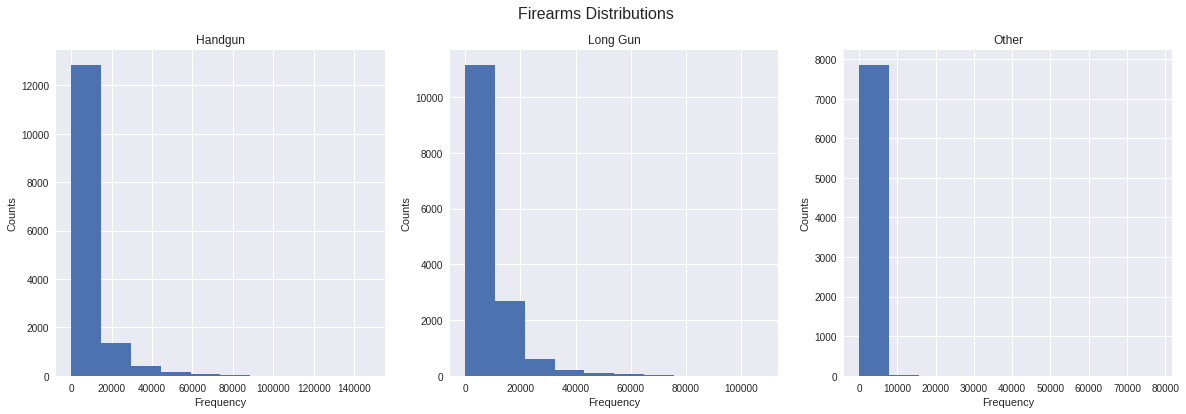

In [ ]:
# Plot Distributions of Firearms

fig, ax = plt.subplots(figsize=(20,6))

plt.subplot(1,3,1) # one row, three axes, axis number 1
plt.hist(nics['handgun'])
plt.title("Handgun")
plt.xlabel('Frequency')
plt.ylabel('Counts')

plt.subplot(1,3,2) # one row, three axes, axis number 2
plt.hist(nics['long_gun'])
plt.title("Long Gun")
plt.xlabel('Frequency')
plt.ylabel('Counts')

plt.subplot(1,3,3) # one row, three axes, axis number 3
plt.hist(nics['other'])
plt.title("Other")
plt.xlabel('Frequency')
plt.ylabel('Counts')

fig.suptitle('Firearms Distributions', fontsize=16);

The above histograms are the distributions of firearms from 1998 to 2021. It shows a right skewed distribution. 

Handgun background checks have more variablity from 0 to 80,000 compared to Long guns or other firearms. From 0 to 18,000 background checks, there are over 13,000 occurring for handguns.

### What days occurs the most background checks?

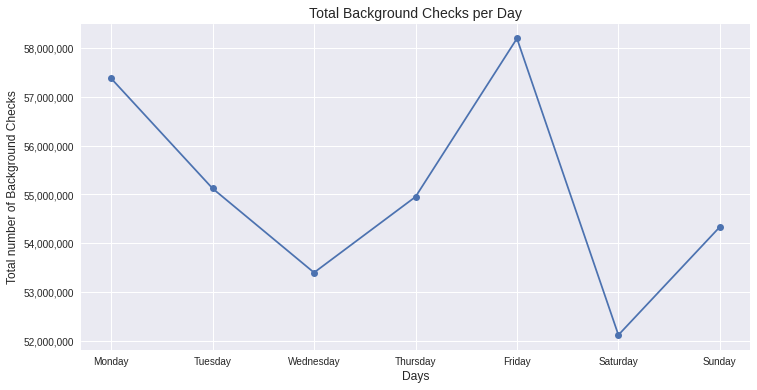

In [131]:
# get the month sum grouped by month
date_checks = nics.groupby(nics.month.dt.weekday).totals.sum()

# create the plot
ax = date_checks.plot(figsize=(12,6), marker='o')

# view the whole sum
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# format labels
labels = ["Buffer", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax.set_xticklabels(labels)

# set axis labels and title
ax.set_title('Total Background Checks per Day', fontsize= 14)
ax.set_xlabel('Days', fontsize = 12)
ax.set_ylabel('Total number of Background Checks', fontsize = 12);

From this visualization, most background checks occurs on **Fridays** then again on **Mondays**. 

### What months occurs the most background checks?

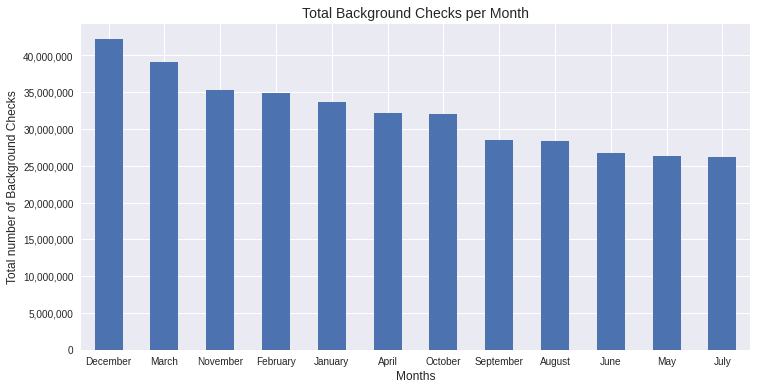

In [132]:
# get the month sum grouped by month
monthly_checks = nics.groupby(nics.month.dt.month_name()).totals.sum().sort_values(ascending=False)

# create the plot
ax = monthly_checks.plot(kind='bar', figsize=(12,6))

# view the whole sum
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# set axis labels and title
ax.set_title('Total Background Checks per Month', fontsize= 14)
ax.set_xlabel('Months', fontsize = 12)
ax.set_xticklabels(monthly_checks.index.tolist(),rotation=0)
ax.set_ylabel('Total number of Background Checks', fontsize = 12);

Most background checks occurs in the holiday month of **December** then followed by **March** and **November**. A quick google search of term ***december nics checks*** will result in headlines that supports this finding. Apparently, one item that pops up on **christmas wishlists** are **guns**.

>*'A gift of safety'*

> From this [article](https://www.flatlandkc.org/news-issues/booming-business-guns-are-a-hot-gift-item-this-holiday-season/)

### What are the trend of background checks?

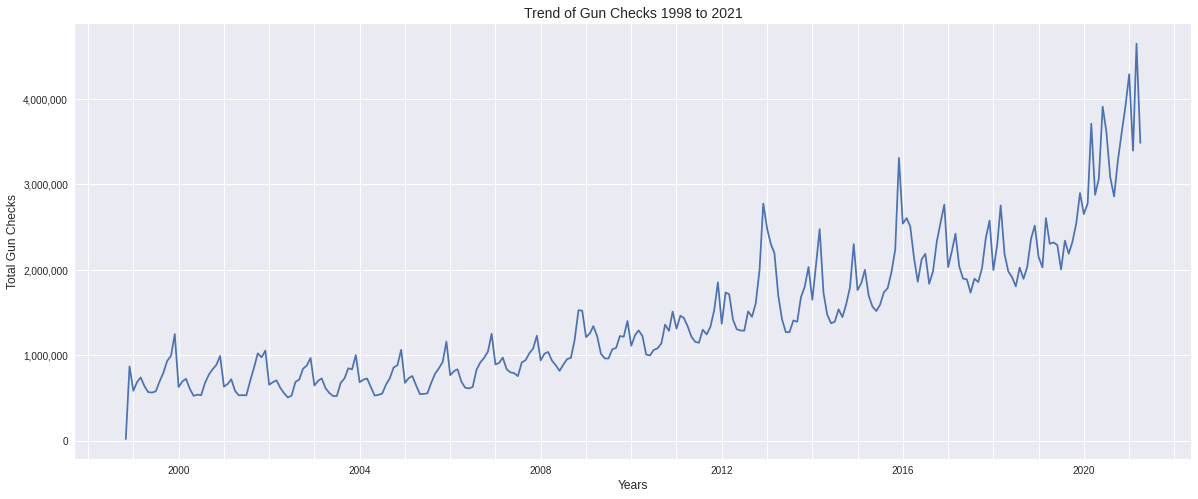

In [133]:
# get the totals sum grouped by month 
summary = nics.groupby("month")['totals'].sum()

# create plot
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(summary)

# format y-axis to show the whole number
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# turn on minor ticks
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(AutoMinorLocator())

# set axis labels
ax.set_title('Trend of Gun Checks 1998 to 2021', fontsize= 14)
ax.set_xlabel('Years', fontsize = 12)
ax.set_ylabel('Total Gun Checks', fontsize = 12);

This line chart shows the yearly pattern, where most background checks occurs in December as seen from the above bar chart, then picks up again in March and goes up again as the year changes to holiday season. 

In December of 2012 background checks almost reached 3 million, in December 2015 the trend crossed the 3 million and in December 2020 it crossed over 4 million background checks.

Next, I will look at yearly totals.

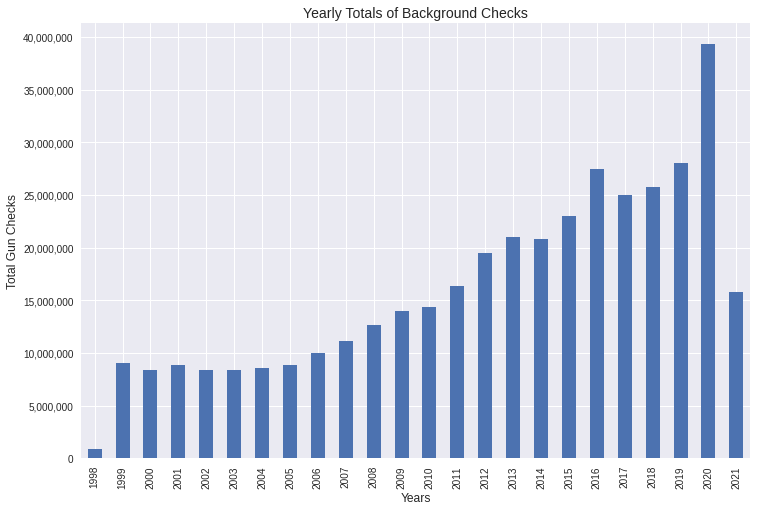

In [134]:
# get yearly sum of background checks
yearly_checks = nics.groupby(nics.month.dt.year).totals.sum()

# create the plot
ax = yearly_checks.plot(kind='bar', figsize=(12,8)) 

# format the y axis labels 
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# set axis labels
ax.set_title('Yearly Totals of Background Checks', fontsize= 14)
ax.set_xlabel('Years', fontsize = 12)
ax.set_ylabel('Total Gun Checks', fontsize = 12);

As said from previous chart, the years 2012, 2016 and 2020 has seen significant activities. 

These years also happens to be election years, it seems that political climate affects the NICS background checks. However note that in previous election years(2000, 2004 and 2008) background checks seems to be in the normal range.

I'm going to subset the dataframe from 2012 and beyond to see this in more detail.

In [135]:
# create a mask
mask2012 = nics['month'] >= '20120101'

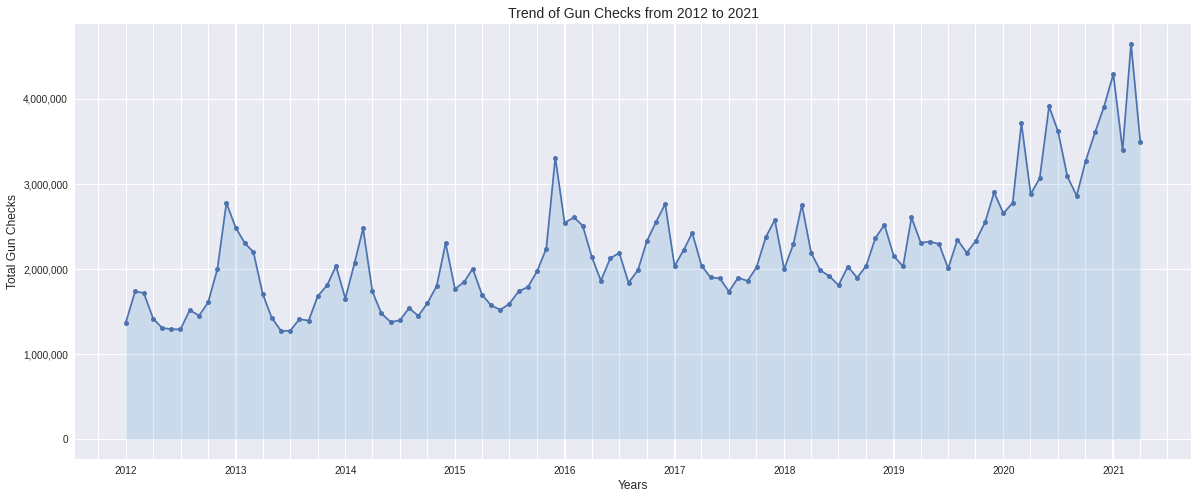

In [136]:
# sum of bacground checks from 2012 and onwards
year2012_and_beyond = nics[mask2012].groupby("month").totals.sum().reset_index()

# separate x and y values
x = year2012_and_beyond.month
y = year2012_and_beyond.totals

# create the plot
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(x,y, marker='o',markersize=5)

# format y-axis to show the whole number
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# turn on minor ticks
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.fill_between(x, y, color='#539ecd', alpha=.2)

# set axis labels
ax.set_title('Trend of Gun Checks from 2012 to 2021', fontsize= 14)
ax.set_xlabel('Years', fontsize = 12)
ax.set_ylabel('Total Gun Checks', fontsize = 12);


Historically, the pattern of background check activity picks up in last quarter of the year then followed by the first quarter of the next year. We can see here that in the beginning of 2019 the pattern has change to more spikes and frequent background checks.  

### Which States have the most background checks per capita in 2016?

Because the census population is only available for 2010 and 2016. I will explore which states have the most background checks per capita in 2016. To do this, I will have to format the `pop_est` column. I will have to remove the commas and format the strings to numeric.

In [137]:
combined['pop_est'].dtypes # currently population estimates is stored as object or strings

dtype('int64')

In [138]:
# clean the population estimates strings
combined['pop_est'] = combined['pop_est'].replace(',','', regex=True)

In [139]:
# transform to numeric type
combined['pop_est'] = combined['pop_est'].apply(pd.to_numeric,errors='coerce')

In [140]:
# create a density column 
combined['density'] = round(combined['pop_est']/combined['totals'],2)

In [141]:
# I was getting errors with infinite numbers being present and this
#   seemed to fix this
combined['density'].replace([np.inf, -np.inf], np.nan, inplace=True)

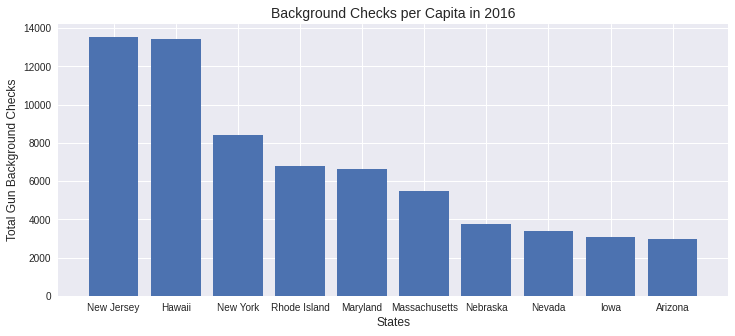

In [142]:
# compute which states had the most background checks per capita
firearms_per_capita = combined.groupby(['state']).density.sum().nlargest(10)

# create the plot 
fig, ax = plt.subplots(figsize=(12,5)) 
states = [x for x in firearms_per_capita.index] # states as labels
ax.bar(states,firearms_per_capita); # plot labels and heights for bar plot

# set axis labels
ax.set_title('Background Checks per Capita in 2016', fontsize= 14)
ax.set_xlabel('States', fontsize = 12)
ax.set_ylabel('Total Gun Background Checks', fontsize = 12);

In 2016 New Jersey and Hawaii ran the most background checks relative to their population. 

### Which States have the most total background checks since the NICS inception?

In [143]:
# compute which states had the most background checks since NICS creation
most_bg_checks = combined.groupby(['state']).totals.sum().nlargest(10)

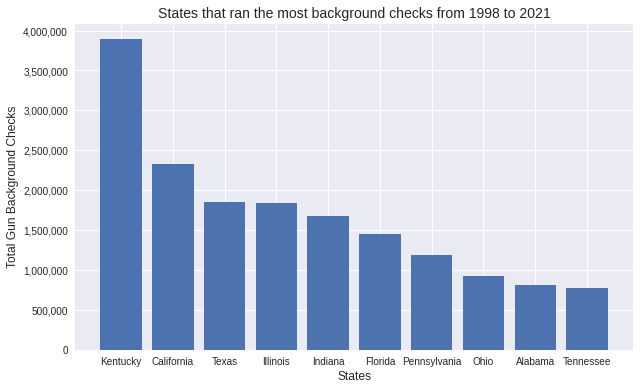

In [144]:
# create the plot
fig, ax = plt.subplots(figsize=(10,6)) 
states = [x for x in most_bg_checks.index] # bar labels 
ax.bar(states,most_bg_checks) # plot the labels and heights

# format y labels
yticks = [ "{0:,.0f}".format(y) for y in ax.get_yticks() ];
ax.set_yticklabels(yticks)

# set axis labels
ax.set_title('States that ran the most background checks from 1998 to 2021', fontsize= 14)
ax.set_xlabel('States', fontsize = 12)
ax.set_ylabel('Total Gun Background Checks', fontsize = 12);

Kentucky by far ran the most checks since the NICS creation. 

This is because Kentucky rans automatic monthly background checks for all concealed carry permit holders to determine if these individuals are still eligible to possess firearms. 

>*A NICS spokesperson confirmed that is because Kentucky is one of few states in the country that performs background checks on concealed carry permits on a monthly basis.*

>From this [article](https://www.wave3.com/story/30671629/in-ky-background-checks-are-performed-on-concealed-carry-permit-holders-on-a-monthly-basis/)

Followed by California, currently a state with most [restrictive gun laws](https://giffords.org/lawcenter/gun-laws/states/california/).

>*California has the strongest gun laws in the United States and has been a trailblazer for gun safety for the past 30 years.*

### Which states have had the highest growth in gun registrations?

To answer this question, I will have to pick ***start*** and ***ending*** years to compare. 

The growth rate formula is: `growth_rate_percentage = ((start - ending)/ending) * 100`


In [145]:
# create masks for 2000 and 2020 
mask_2000 = (nics['month'] >= '20000101') & (nics['month'] <= '20001231')
mask_2020 = (nics['month'] >= '20200101') & (nics['month'] <= '20201231')

In [146]:
# assign it to new dataframes
state_totals_2000 = nics[mask_2000].groupby('state').totals.sum()
state_totals_2020 = nics[mask_2020].groupby('state').totals.sum()

In [147]:
# concatenate the tables by columns
states_checks_2000_2020 = pd.concat([state_totals_2000, state_totals_2020], axis=1)

In [148]:
states_checks_2000_2020

totals   totals
state                                
Alabama               221911  1085475
Alaska                 39959    98952
Arizona               148263   665458
Arkansas              169628   324741
California            794506  1601054
Colorado              307512   680507
Connecticut            87586   219227
Delaware               15347    77057
District of Columbia      17    11485
Florida               266035  1912204
Georgia               352357   904035
Guam                     279     3572
Hawaii                  6609    20102
Idaho                  77138   281284
Illinois              449771  7455065
Indiana               182319  1935587
Iowa                   87796   270614
Kansas                 96716   249589
Kentucky              229896  3330462
Louisiana             174706   430537
Maine                  45028   137149
Mariana Islands           13      222
Maryland               84309   302563
Massachusetts          54843   262583
Michigan              300661  1068511
Minnesota             185100   958391
Mississippi           163980   366829
Missouri              191578   708184
Montana                71115   172695
Nebraska               44825   104511
Nevada                 49807   219349
New Hampshire          40120   174662
New Jersey             37106   177901
New Mexico             84034   206252
New York              163974   507940
North Carolina        290884   890284
North Dakota           32358    85465
Ohio                  274165   976751
Oklahoma              156988   470286
Oregon                135336   516096
Pennsylvania          481294  1452921
Puerto Rico             5301    31671
Rhode Island            9414    51369
South Carolina        128618   530930
South Dakota           36723   115448
Tennessee             234673   984760
Texas                 662970  2325281
Utah                   67420  1216773
Vermont                20300    57965
Virgin Islands             0     1639
Virginia              188508   823513
Washington            134255   781471
West Virginia         128258   265705
Wisconsin             180492   731618
Wyoming                34295    91384

In [149]:
# rename the columns 2000 and 2020
states_checks_2000_2020.columns=['2000','2020']

In [150]:
# compute the growth rate using formula: growth_rate_percentage = ((start - ending)/ending) * 100
ending = states_checks_2000_2020['2020']
start = states_checks_2000_2020['2000']

# assign to a new column
states_checks_2000_2020['growth_rate_percentage'] = round( (( ending - start ) / start) * 100, 2)

In [151]:
states_checks_2000_2020 # Virgin Islands growth has inf values

2000     2020  growth_rate_percentage
state                                                        
Alabama               221911  1085475                  389.15
Alaska                 39959    98952                  147.63
Arizona               148263   665458                  348.84
Arkansas              169628   324741                   91.44
California            794506  1601054                  101.52
Colorado              307512   680507                  121.29
Connecticut            87586   219227                  150.30
Delaware               15347    77057                  402.10
District of Columbia      17    11485                67458.82
Florida               266035  1912204                  618.78
Georgia               352357   904035                  156.57
Guam                     279     3572                 1180.29
Hawaii                  6609    20102                  204.16
Idaho                  77138   281284                  264.65
Illinois              449771  7455065                 1557.52
Indiana               182319  1935587                  961.65
Iowa                   87796   270614                  208.23
Kansas                 96716   249589                  158.06
Kentucky              229896  3330462                 1348.68
Louisiana             174706   430537                  146.44
Maine                  45028   137149                  204.59
Mariana Islands           13      222                 1607.69
Maryland               84309   302563                  258.87
Massachusetts          54843   262583                  378.79
Michigan              300661  1068511                  255.39
Minnesota             185100   958391                  417.77
Mississippi           163980   366829                  123.70
Missouri              191578   708184                  269.66
Montana                71115   172695                  142.84
Nebraska               44825   104511                  133.15
Nevada                 49807   219349                  340.40
New Hampshire          40120   174662                  335.35
New Jersey             37106   177901                  379.44
New Mexico             84034   206252                  145.44
New York              163974   507940                  209.77
North Carolina        290884   890284                  206.06
North Dakota           32358    85465                  164.12
Ohio                  274165   976751                  256.26
Oklahoma              156988   470286                  199.57
Oregon                135336   516096                  281.34
Pennsylvania          481294  1452921                  201.88
Puerto Rico             5301    31671                  497.45
Rhode Island            9414    51369                  445.67
South Carolina        128618   530930                  312.80
South Dakota           36723   115448                  214.38
Tennessee             234673   984760                  319.63
Texas                 662970  2325281                  250.74
Utah                   67420  1216773                 1704.77
Vermont                20300    57965                  185.54
Virgin Islands             0     1639                     inf
Virginia              188508   823513                  336.86
Washington            134255   781471                  482.08
West Virginia         128258   265705                  107.16
Wisconsin             180492   731618                  305.35
Wyoming                34295    91384                  166.46

In [152]:
# replace inf with Nan then drop Nan
states_checks_2000_2020.replace([np.inf, -np.inf], np.nan, inplace=True)
states_checks_2000_2020.dropna()

2000     2020  growth_rate_percentage
state                                                        
Alabama               221911  1085475                  389.15
Alaska                 39959    98952                  147.63
Arizona               148263   665458                  348.84
Arkansas              169628   324741                   91.44
California            794506  1601054                  101.52
Colorado              307512   680507                  121.29
Connecticut            87586   219227                  150.30
Delaware               15347    77057                  402.10
District of Columbia      17    11485                67458.82
Florida               266035  1912204                  618.78
Georgia               352357   904035                  156.57
Guam                     279     3572                 1180.29
Hawaii                  6609    20102                  204.16
Idaho                  77138   281284                  264.65
Illinois              449771  7455065                 1557.52
Indiana               182319  1935587                  961.65
Iowa                   87796   270614                  208.23
Kansas                 96716   249589                  158.06
Kentucky              229896  3330462                 1348.68
Louisiana             174706   430537                  146.44
Maine                  45028   137149                  204.59
Mariana Islands           13      222                 1607.69
Maryland               84309   302563                  258.87
Massachusetts          54843   262583                  378.79
Michigan              300661  1068511                  255.39
Minnesota             185100   958391                  417.77
Mississippi           163980   366829                  123.70
Missouri              191578   708184                  269.66
Montana                71115   172695                  142.84
Nebraska               44825   104511                  133.15
Nevada                 49807   219349                  340.40
New Hampshire          40120   174662                  335.35
New Jersey             37106   177901                  379.44
New Mexico             84034   206252                  145.44
New York              163974   507940                  209.77
North Carolina        290884   890284                  206.06
North Dakota           32358    85465                  164.12
Ohio                  274165   976751                  256.26
Oklahoma              156988   470286                  199.57
Oregon                135336   516096                  281.34
Pennsylvania          481294  1452921                  201.88
Puerto Rico             5301    31671                  497.45
Rhode Island            9414    51369                  445.67
South Carolina        128618   530930                  312.80
South Dakota           36723   115448                  214.38
Tennessee             234673   984760                  319.63
Texas                 662970  2325281                  250.74
Utah                   67420  1216773                 1704.77
Vermont                20300    57965                  185.54
Virginia              188508   823513                  336.86
Washington            134255   781471                  482.08
West Virginia         128258   265705                  107.16
Wisconsin             180492   731618                  305.35
Wyoming                34295    91384                  166.46

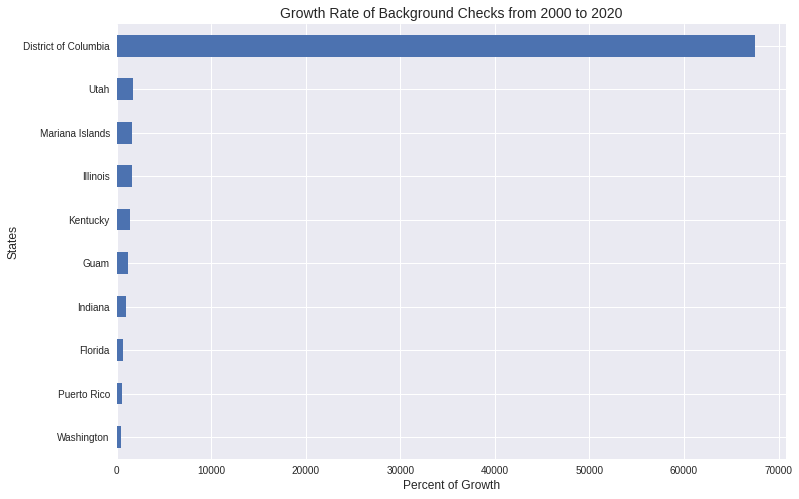

In [153]:
# get the top 10 states with most growth in background checks
n = 10
growth_rates = states_checks_2000_2020.groupby(['state']).growth_rate_percentage.sum().nlargest(n).sort_values(ascending=True)

# create the plot
ax = growth_rates.plot(kind='barh', figsize=(12,8)) 

# set axis labels
ax.set_title('Growth Rate of Background Checks from 2000 to 2020', fontsize= 14)
ax.set_xlabel('Percent of Growth', fontsize = 12)
ax.set_ylabel('States', fontsize = 12);

In [154]:
growth_rates.sort_values(ascending=False)

state
District of Columbia    67458.82
Utah                     1704.77
Mariana Islands          1607.69
Illinois                 1557.52
Kentucky                 1348.68
Guam                     1180.29
Indiana                   961.65
Florida                   618.78
Puerto Rico               497.45
Washington                482.08
Name: growth_rate_percentage, dtype: float64

The District of Columbia has seen a whopping growth rate of 67,458% increase in background checks in from 2000 to 2020. 

>DC is one of the thirteen states that require universal background checks at the point of sale for all sales and transfers of all classes of firearms, whether they are purchased from a licensed dealer or an unlicensed seller.  

>Taken from this [article](https://giffords.org/lawcenter/gun-laws/policy-areas/background-checks/universal-background-checks/)

## Conclusions

The NICS Background check does not necessarily means that an individual purchase a gun. It is an attempt to obtain firearm and that one may have had multiple purchases in one check. Also Kentucky runs a new check each month for all concealed carry permits. However, the NICS data is widely accepted proxy in estimating nationwide firearm sales. 

* Fridays, followed by Mondays are days where most background checks occurs.
* December, March and November are months where most background checks occurs. Guns apparently makes it to christmas wishlists.     
* The trend of background checks seems to be affected by political climate primarily election years as seen from the above line plot. It has been trending up and continues to go up. 
* In 2016, New Jersey and Hawaii had conducted the most background checks. 
* From 2000 to 2020, DC has seen a whopping 67,458 percent increase in background checks.

## Limitations

As stated in the data exploration section, there are some limitations in this study. 

*   The NICS background check doesn't correlate with a firearm sale. The check is merely an attempt to purchase a firearm.  
*   As stated in earlier section, I was interested in further exploring what demographic features are associated with more background checks. This was not possible since the NICS dataset does not keep track of this information.
* The census data is limited to only 2010 and 2016. This study only explored 2016 census population.



